In [1]:
#Install
!pip install -U scikit-learn

     |████████████████████████████████| 24.8 MB 9.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [10]:
#Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [11]:
# download file
!wget -nc https://lazyprogrammer.me/course_files/timeseries/perrin-freres-monthly-champagne.csv

File ‘perrin-freres-monthly-champagne.csv’ already there; not retrieving.



In [12]:
#Buat dataframe
df = pd.read_csv('perrin-freres-monthly-champagne.csv',index_col='Month',skipfooter=2,parse_dates=True)

df.columns = ['Sales']

#Buat kolom baru
df['LogSales'] = np.log(df['Sales'])

#Buat variable baru untuk data training dan testing
Ntest = 12
train = df.iloc[:-Ntest] # data < tail(12)
test = df.iloc[-Ntest:] # data = tail(12)

#Buat supervised dataset
#Mari lihat apakah kita dapat menggunakan nilai T-past untuk memprediksi nilai selanjutnya 
series = df['LogSales'].to_numpy()[1:]

#Buat variable dan array
T = 12
X = []
Y = []

#Buat perulangan untuk mengisi array X dan Y
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

#Ubah menjadi ndarray dan lakukan reshape
X = np.array(X).reshape(-1, T)
Y = np.array(Y)

#Hitung banyaknya data dari array X
N = len(X)

#Display
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (92, 12) Y.shape (92,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [15]:
#Buat variable untuk data training dan testing
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

#Buat model
lr = LinearRegression()

#Fit model
lr.fit(Xtrain, Ytrain)

#Display score dari model
print("Score model LR data train:", lr.score(Xtrain, Ytrain))
print("Score model LR data test:", lr.score(Xtest, Ytest))

Score model LR data train: 0.8716534207954165
Score model LR data test: 0.9639502198549218


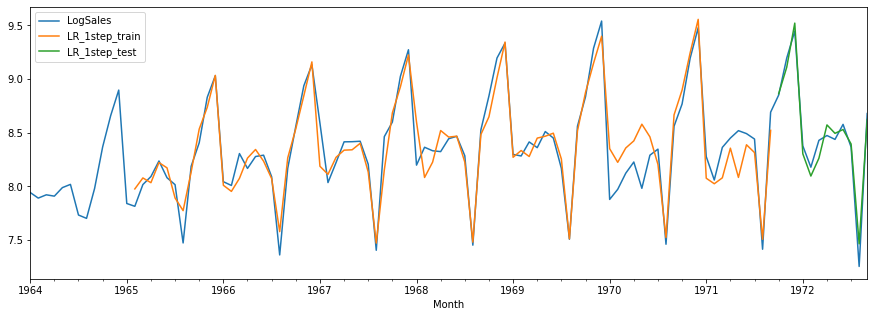

In [19]:
#Boolean index
#Buat variable
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # nilai T pertama tidak dapat diprediksi

#1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

#Plot 1-step forecast
df[['LogSales', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

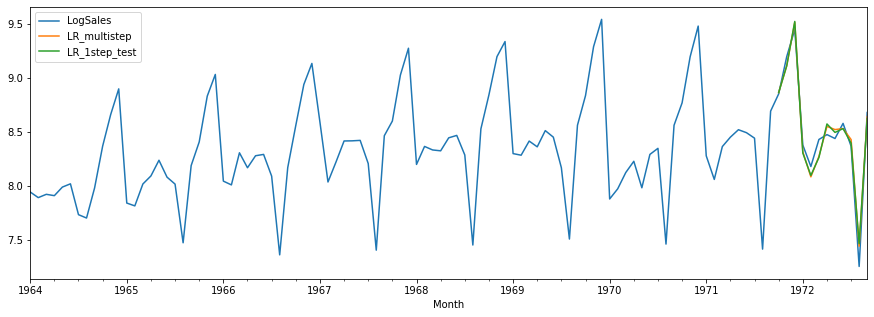

In [21]:
#Multi-step forecast
multistep_predictions = []

#Buat variable untuk input nilai pertama data testing
last_x = Xtest[0]

#Buat perulangan
while len(multistep_predictions) < Ntest:
  #Buat variable
  p = lr.predict(last_x.reshape(1, -1))[0]
  
  #Update predictions list
  multistep_predictions.append(p)
  
  #Buat input baru
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

#Simpan multi-step forecast ke dalam dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

#Plot 1-step and multi-step forecast
df[['LogSales', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));

In [22]:
#Buat multi-output supervised dataset

#Buat variable
Tx = T
Ty = Ntest

#Buat array
X = []
Y = []

#Buat perulangan
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

#Ubah data menjadi ndarray dan reshape
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

#Buat variable untuk mengetahui jumlah data array X
N = len(X)

#Display
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (81, 12) Y.shape (81, 12)


In [24]:
#Buat variable untuk data training dan testing
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

#Buat model
lr = LinearRegression()

#Fit model
lr.fit(Xtrain_m, Ytrain_m)

#Score model
print("Score model LR data train:", lr.score(Xtrain_m, Ytrain_m))
print("Score model LR data test:", lr.score(Xtrain_m, Ytrain_m))

Score model LR data train: 0.8830666358110193
Score model LR data test: 0.8830666358110193


In [25]:
#Hitung R2
print("Score R2:", r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten()))

Score R2: 0.9595234428105757


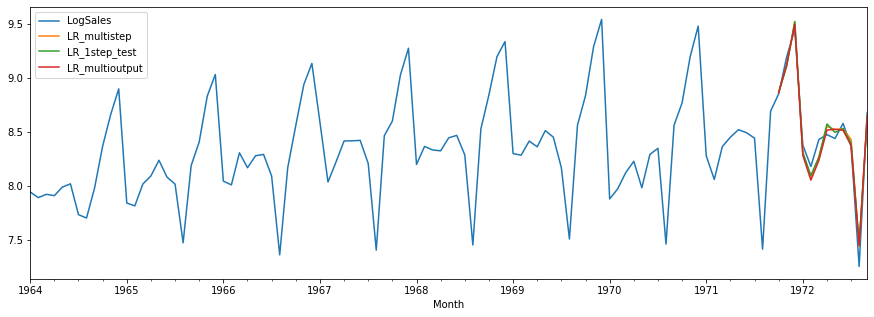

In [28]:
#Simpan multi-output forecast ke dalam dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

#Plot semua forecasts
cols = ['LogSales', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [30]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogSales']
mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.009790806113745658
multi-output MAPE: 0.009736441362578199


# Tes model lainnya

In [37]:
#Buat fungsi
def one_step_and_multistep_forecast(model, name):
  #Fit model
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  print("Train R^2:", model.score(Xtrain, Ytrain))
  print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  #1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  #Multi-step forecast
  multistep_predictions = []

  #Input data testing pertama
  last_x = Xtest[0]

  #Buat perulangan
  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    #Update predictions list
    multistep_predictions.append(p)
    
    #Buat inputan baru
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  #Multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  #MAPE multi-step forecast
  mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
  print("Test MAPE (multi-step):", mape)

  #Plot 1-step and multi-step forecast
  cols = [
    'LogSales',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Train R^2: 0.9566057531411206
Test R^2 (1-step): 0.9180752776246474
Test MAPE (multi-step): 0.013547771381900135


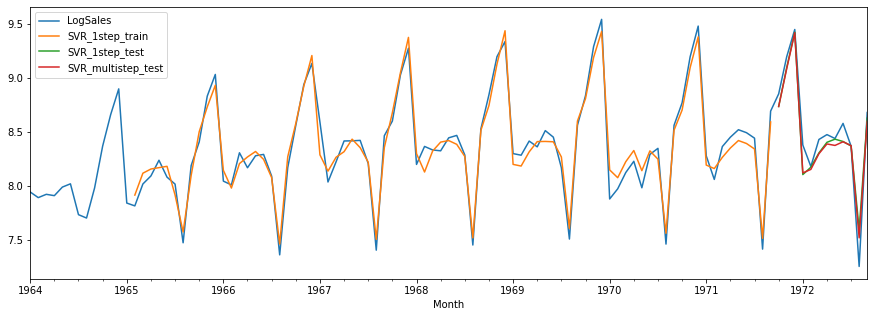

In [38]:
#Tes fungsi dengan SVR
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Train R^2: 0.9777401096342664
Test R^2 (1-step): 0.9521801382519658
Test MAPE (multi-step): 0.011217769573673965


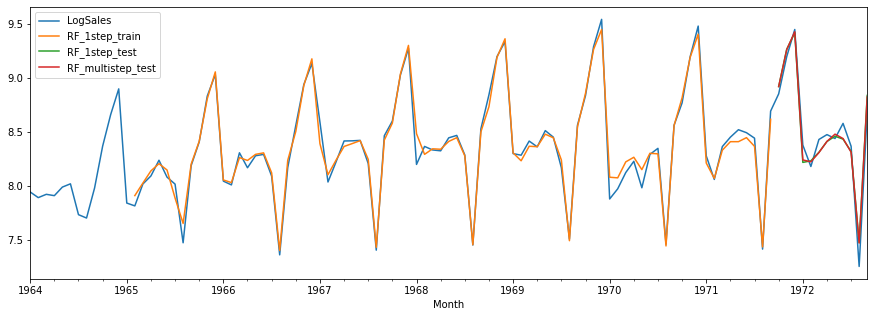

In [39]:
#Tes fungsi dengan RandomForest
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [41]:
#Buat fungsi ke-2
def multi_output_forecast(model, name):
  #Fit model
  model.fit(Xtrain_m, Ytrain_m)
  
  #Simpan multi-output forecast ke dalam dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()
  
  #Buat MAPE
  mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  #Plot all forecasts
  #Asumsikan bahwa fungsi sebelumnya telah dijalankan
  cols = [
    'LogSales',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols].plot(figsize=(15, 5));

In [42]:
#Multi_output_forecast(SVR(), "SVR") # => tidak bisa handle multi-output

Test MAPE (multi-output): 0.014361966274657717


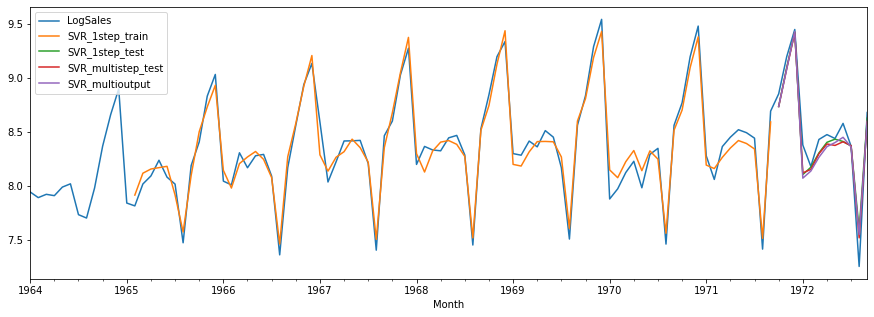

In [43]:
#Maka dibuat menjadi seperti ini
class SVRWrapper:
  def __init__(self, h, **args):
    self.h = h
    self.models = [SVR(**args) for _ in range(h)]
  
  def fit(self, X, Y):
    for k in range(self.h):
      self.models[k].fit(X, Y[:, k])
  
  def predict(self, X):
    P = [m.predict(X) for m in self.models]
    return np.hstack(P)

#Display
multi_output_forecast(SVRWrapper(Ntest), "SVR")

Test MAPE (multi-output): 0.02077777983752648


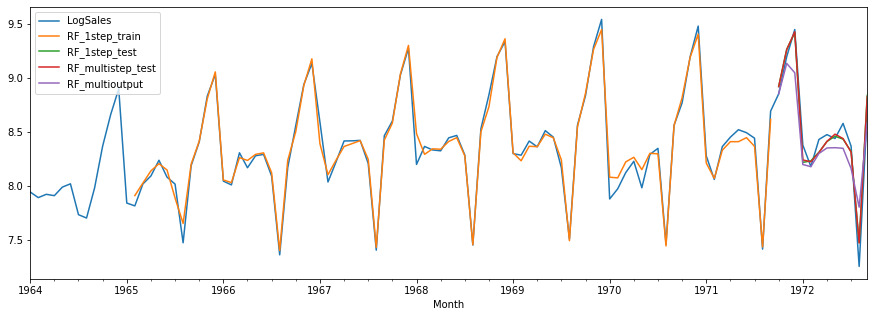

In [44]:
multi_output_forecast(RandomForestRegressor(), "RF")